In [1]:
from __future__ import absolute_import, division, print_function

import pandas as pd
import numpy as np
import sklearn as sk
import os
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import h5py as h5py
from time import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

# %load_ext autoreload
# %autoreload 2

In [23]:
data = np.load("processed_data.npz")

In [24]:
data.files

['x_train', 'y_train', 'x_valid', 'y_valid', 'x_test', 'y_test']

In [25]:
data_path = "data/"

final_df_train = pd.read_csv(data_path + 'train_state_action_reward_df.csv')
final_df_val = pd.read_csv(data_path+ 'val_state_action_reward_df.csv')

In [26]:
data['x_train'].shape

(153582, 47)

In [92]:
def term(df):
    if df.reward == 0:
        return "continue"
    if df.reward == 15:
        return "released"
    if df.reward == -15:
        return "died"
    
labels_train = final_df_train[['reward']].apply(term, axis=1).values.reshape(-1, 1)
labels_valid = final_df_val[['reward']].apply(term, axis=1).values.reshape(-1, 1)


enc = OneHotEncoder()
enc.fit(labels_train)

labels_train_one_hot = enc.transform(labels_train)
labels_valid_one_hot = enc.transform(labels_valid)

In [93]:
labels_train_one_hot.shape

(153582, 3)

In [110]:
max_episode = 10

def get_padded_matrix(x_, y_):
    episode_matrix = np.zeros(shape=[x_.shape[0], max_episode, x_.shape[1]])
    episode = []
    labels_episode = []
    for idx in range(len(x_)):
        # within on episode
        episode.append(x_[idx])
        for event_idx in range(min(len(episode), max_episode)):
            episode_matrix[idx][-(event_idx%max_episode)-1] = episode[-event_idx - 1]
        if np.equal(x_[idx][:-1],y_[idx]).all():
            # episode changed
            episode = []
    return episode_matrix

In [111]:
train_matrix = get_padded_matrix( data['x_train'],  data['y_train'])

In [112]:
valid_matrix = get_padded_matrix( data['x_valid'],  data['y_valid'])

In [113]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, input_shape=(train_matrix.shape[1], train_matrix.shape[2])),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [114]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 50)                19600     
_________________________________________________________________
dense_11 (Dense)             (None, 128)               6528      
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 387       
Total params: 26,515
Trainable params: 26,515
Non-trainable params: 0
_________________________________________________________________


In [115]:
optimizer = keras.optimizers.Adam()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [122]:
valid_matrix.shape
labels_train_one_hot.shape

(153582, 3)

In [123]:
train_matrix.shape
labels_valid_one_hot.shape

(19527, 3)

In [126]:
tensorboard = keras.callbacks.TensorBoard(log_dir="logs/mortality{}".format(time()))
model.fit(train_matrix, labels_train_one_hot, epochs=10, batch_size=1000, validation_data=(valid_matrix, labels_valid_one_hot), callbacks=[tensorboard])

Train on 153582 samples, validate on 19527 samples
Epoch 1/10
153582/153582 [==============================] - 9s 57us/step - loss: 0.2523 - acc: 0.9119 - val_loss: 0.2519 - val_acc: 0.9135
Epoch 2/10
153582/153582 [==============================] - 10s 62us/step - loss: 0.2500 - acc: 0.9122 - val_loss: 0.2511 - val_acc: 0.9137
Epoch 3/10
153582/153582 [==============================] - 8s 55us/step - loss: 0.2487 - acc: 0.9124 - val_loss: 0.2505 - val_acc: 0.9137
Epoch 4/10
153582/153582 [==============================] - 9s 56us/step - loss: 0.2476 - acc: 0.9124 - val_loss: 0.2503 - val_acc: 0.9134
Epoch 5/10
153582/153582 [==============================] - 9s 60us/step - loss: 0.2465 - acc: 0.9126 - val_loss: 0.2499 - val_acc: 0.9137
Epoch 6/10
153582/153582 [==============================] - 9s 59us/step - loss: 0.2454 - acc: 0.9128 - val_loss: 0.2491 - val_acc: 0.9143
Epoch 7/10
153582/153582 [==============================] - 9s 62us/step - loss: 0.2445 - acc: 0.9129 - val_loss: 

In [128]:
model.save_weights("mortality_weights.h5py")

In [129]:
valid_predicted = model.predict(valid_matrix)

In [130]:
train_predicted = model.predict(train_matrix)

In [ ]:
sns.set(style="white")

def plot(column, mode="valid", prediction=valid_predicted):
    from matplotlib.pyplot import figure
    figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(data['y_'+mode][0:20,columns.index(column)], label="truth")
    plt.plot(prediction[0:20,columns.index(column)], label="predicted")
    plt.legend(["truth", "predicted"])
    plt.title(column + " " + mode)
    plt.show()

In [ ]:
valid_matrix[1]

In [ ]:
data['y_valid'][1]

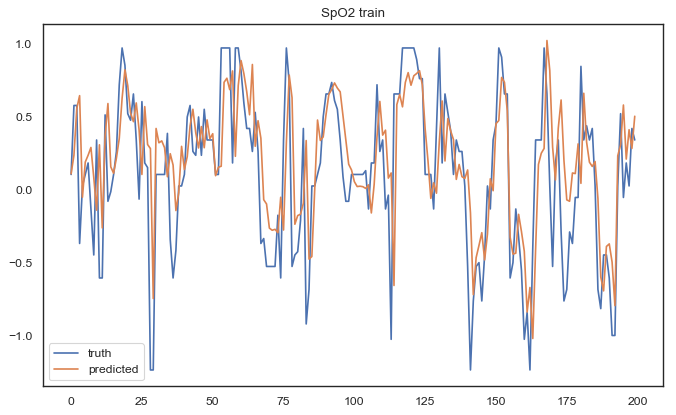

In [114]:
plot("SpO2", "train", train_predicted)

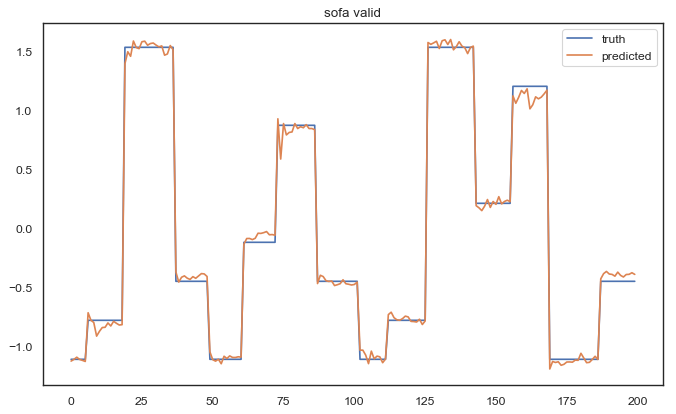

In [116]:
plot("sofa")

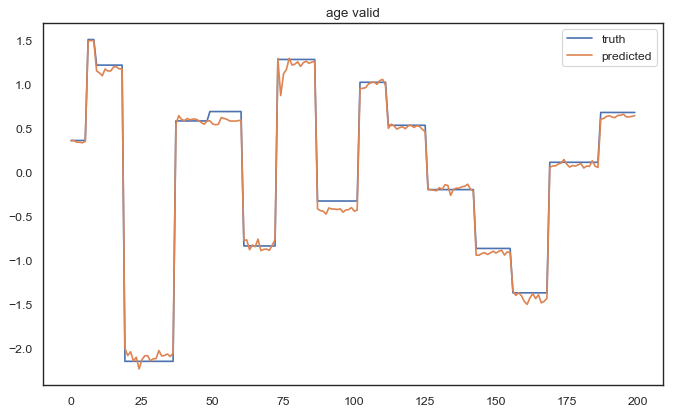

In [117]:
plot("age")

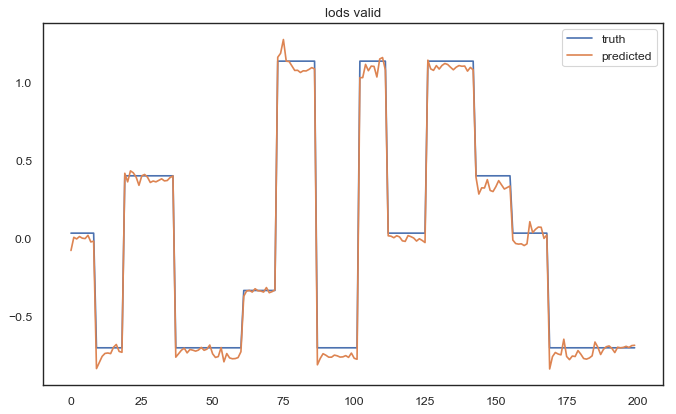

In [118]:
plot("lods")

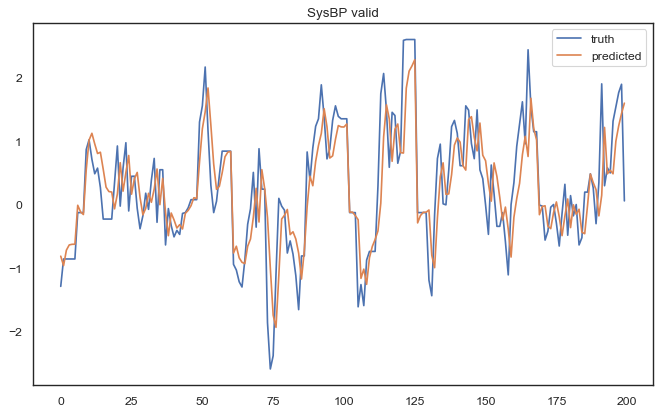

In [119]:
plot("SysBP")

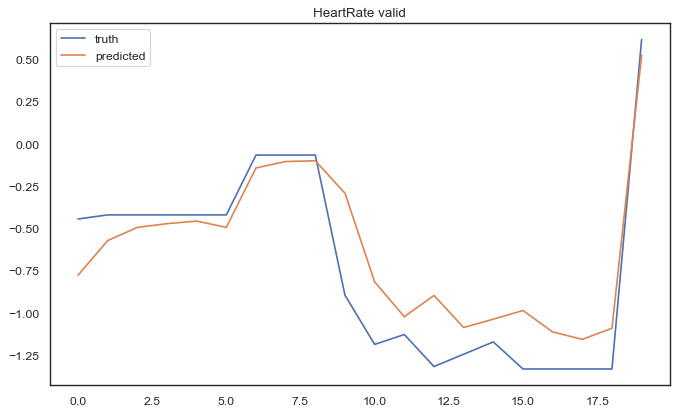

In [124]:
plot("HeartRate")

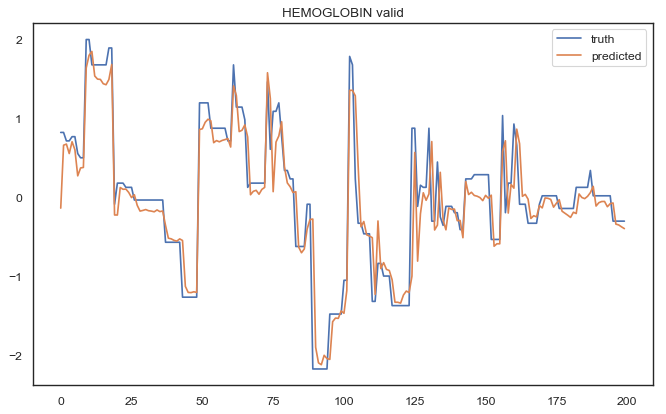

In [121]:
plot("HEMOGLOBIN")

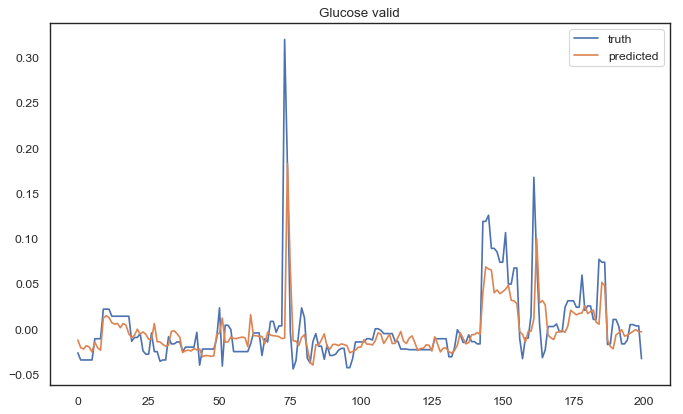

In [122]:
plot("Glucose")